# Checking the performance of `pympc` positions vs the Minor Planet Center (MPC)

Here we use a large search cone to find accurate Minor Planet Center (MPC) positions of minor bodies and compare them to `pympc` outputs., whilst varying the query epoch to simulate increasing outdated local catalogue of ephemerides.

> **TL;DR**
> For timescales within a month or so of the reference epoch of the local catalogue, ~all the minor bodies returned by Minor Planet Center are matched within a few arcseconds by `pympc`. Beyond 3 months there is a significant degradation of matching performance.



### Query epoch vs. Reference epoch

We will test scenarios involving increasing separation of the epochs between when we are requesting `pympc` position of objects (*query epoch*) and when the orbital elements are computed for in the local ephemeris catalogue (*reference epoch*). One is an idealised case where the epochs are the same, as well as separtions of 1, 3 and 6 months. Given the Minor Planet Center updates their orbital catalogue reference epochs on roughly monthly cadence, separations of less than one month is typical for real-time work, but the 3 and 6 month separations give an idea of degredation when trying to match historical (or far future) positions with respect to the reference epoch.

## Setup

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
from astropy.time import Time

import pympc

### Update catalogue (done on 2024-08-25)

Here we update once the `pympc` local catalogue, which fixes our reference epoch

In [2]:
# pympc.update_catalogue(cat_dir=".")

'/tmp/mpcorb_xephem.csv'

In [2]:
# Get the reference epoch of the downloaded data
with open("./mpcorb_xephem.csv") as f:
    line = f.readline()
epoch_decimalyear = line.split(",")[9]
print(f"Reference epoch is {Time(epoch_decimalyear, format='decimalyear').iso}")

Reference epoch is 2024-10-16 23:58:50.849


#### Search and store Minor Planet Center's online results

A large 300-arcminute cone centred on ra=dec=0 was searched via the [MPChecker](https://www.minorplanetcenter.net/cgi-bin/checkmp.cgi) service using the reference epoch date (actually midnight thereof) and plus 1, 3, and 6 months from that date, and observatory code 950. (The searches were performed on 2024-08-25.) After some minor manual cleanup of the catalogues, they have been stored as `.txt` files in this directory.

Function to load the MPCenter results:

In [3]:
def read_mpc_results(filename):
    mpc_tbl_ = Table.read(
        filename,
        format="ascii.fixed_width",
        col_starts=(9,25, 36, 47),
        col_ends=(24,34, 45, 50)
    )
    mpc_tbl_["mpc_coords"] = SkyCoord(ra=mpc_tbl_["R.A."], dec=mpc_tbl_["Decl."], unit=(u.hourangle, u.deg))
    # Need to have same column name as pympc table to join tables
    mpc_tbl_.rename_column("designation", "name")
    # Remove any with any masked values
    mpc_tbl_.remove_rows(np.where([c.data for c in mpc_tbl_.mask.itercols()])[-1])
    return mpc_tbl_

#### Perform the same searches with `pympc` offline

A function to call `pympc` at a given epoch

In [4]:
def get_pympc_results(epoch):
    search_radius = 300 * u.arcmin
    ra = 0 * u.deg
    dec = 0 * u.deg
    max_mag = 24
    obs_code = 950
    pympc_tbl_ = pympc.minor_planet_check(ra, dec, epoch, search_radius, xephem_filepath="./mpcorb_xephem.csv", max_mag=max_mag, observatory=obs_code)
    pympc_tbl_["pympc_coords"] = SkyCoord(ra=pympc_tbl_["ra"], dec=pympc_tbl_["dec"], unit=(u.deg, u.deg))
    del pympc_tbl_["xephem_str"]
    return pympc_tbl_

#### Compare the results

In [5]:
epoch_names = [
    "None",
    "+1 month",
    "+3 month",
    "+6 month",
]
mpc_result_filepaths = [
    "minor_planet_center_results_current.txt",
    "minor_planet_center_results_plus1month.txt",
    "minor_planet_center_results_plus3month.txt",
    "minor_planet_center_results_plus6month.txt",
]
pympc_epochs = [
    Time("2024-10-17").mjd,
    Time("2024-11-17").mjd,
    Time("2025-01-17").mjd,
    Time("2025-04-17").mjd,
]
seps = []
for epoch_name, mpc_result_filepath, pympc_epoch in zip(epoch_names, mpc_result_filepaths, pympc_epochs):
    mpc_tbl = read_mpc_results(mpc_result_filepath)
    pympc_tbl = get_pympc_results(pympc_epoch)
    # Join the tables so that we can easily access the coordinates from each
    joined_tbl = join(pympc_tbl, mpc_tbl, keys="name")
    sep = joined_tbl[f"mpc_coords"].separation(joined_tbl[f"pympc_coords"]).to(u.arcsec)
    seps.append(sep)

Epoch separation: None
	99.84% of the MPC results are within 4 arcsec of pympc positions
	0.593 arcsec is the median separation
-------------------------------------------------------------------------------
Epoch separation: +1 month
	99.81% of the MPC results are within 4 arcsec of pympc positions
	0.669 arcsec is the median separation
-------------------------------------------------------------------------------
Epoch separation: +3 month
	99.71% of the MPC results are within 4 arcsec of pympc positions
	1.414 arcsec is the median separation
-------------------------------------------------------------------------------
Epoch separation: +6 month
	0.78% of the MPC results are within 4 arcsec of pympc positions
	6.295 arcsec is the median separation
-------------------------------------------------------------------------------


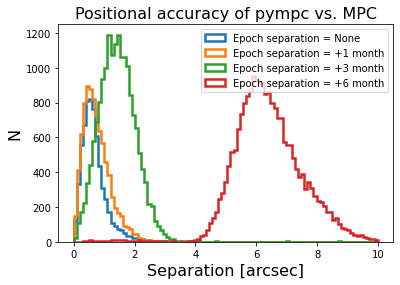

In [7]:
for epoch_name, sep in zip (epoch_names, seps):
    _ = plt.hist(sep.value, bins=np.linspace(0, 10, 100), histtype="step", lw=2.5, label=f"Epoch separation = {epoch_name}")
    print(f"Epoch separation: {epoch_name}")
    print(f"\t{100*np.sum(sep < 4 * u.arcsec)/len(sep):.2f}% of the MPC results are within 4 arcsec of pympc positions")
    print(f"\t{np.median(sep):.3f} is the median separation")
    print("-"*79)

plt.legend(frameon=True)
plt.xlabel("Separation [arcsec]", size=16)
plt.ylabel("N", size=16)
plt.title("Positional accuracy of pympc vs. MPC", size=16)
plt.savefig("position_accuracy.png")